<a href="https://colab.research.google.com/github/akfangus/MLproject/blob/main/%EB%89%B4%EC%9A%95_%ED%83%9D%EC%8B%9C%EC%9A%94%EA%B8%88_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction


  0%|          | 0.00/1.56G [00:00<?, ?B/s]
  0%|          | 5.00M/1.56G [00:00<02:01, 13.8MB/s]
  1%|          | 9.00M/1.56G [00:00<01:24, 19.6MB/s]
  1%|1         | 17.0M/1.56G [00:00<00:45, 36.1MB/s]
  1%|1         | 23.0M/1.56G [00:00<00:38, 43.2MB/s]
  2%|2         | 32.0M/1.56G [00:00<00:29, 56.2MB/s]
  2%|2         | 39.0M/1.56G [00:01<00:42, 38.9MB/s]
  3%|2         | 44.0M/1.56G [00:01<00:40, 40.6MB/s]
  3%|3         | 49.0M/1.56G [00:01<00:38, 42.2MB/s]
  4%|3         | 57.0M/1.56G [00:01<00:35, 44.9MB/s]
  4%|4         | 65.0M/1.56G [00:01<00:38, 42.1MB/s]
  5%|4         | 73.0M/1.56G [00:01<00:38, 41.0MB/s]
  5%|5         | 81.0M/1.56G [00:02<00:33, 47.7MB/s]
  6%|5         | 89.0M/1.56G [00:02<00:32, 48.4MB/s]
  6%|6         | 97.0M/1.56G [00:02<00:32, 49.1MB/s]
  7%|6         | 105M/1.56G [00:02<00:33, 47.0MB/s] 
  7%|7         | 113M/1.56G [00:02<00:41, 37.9MB/s]
  8%|7         | 121M/1.56G [00:03<00:34, 45.1MB/s]
  8%|8         | 128M/1.56G [00:03<00:30, 50.4MB/s]
  9%

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm, skew

import os
from PIL import Image

style.use('seaborn-talk')

krfont={'family':'Malgun Gothic', 'weight': 'bold', 'size' : 10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline


# 데이터 read
- 5GB짜리 train데이터를 한번에 읽을수가 없다.
- 이때 어떻게 해야하나?
- 계통추출을 통해 데이터를 불러오기도 함.
- chuck로 읽는 갯수를 나눠서 합치는 방법으로 함여기서는

- 이거 데이터처리가 너무 느려서
- 일단 실습자체는 데이터 갯수 줄여서
- 추후 빅데이터 read 하둡,스파크 공부해서 해봐야할듯

In [ ]:
def skip_logic(index, skip_num):
    if index % skip_num == 0:
        return False
    return True

In [ ]:
import pandas as pd 
import dask.dataframe as dd
import os
from tqdm import tqdm

TRAIN_PATH = 'new-york-city-taxi-fare-prediction/train.csv'

In [ ]:
%%time
# Assume we only know that the csv file is somehow large, but not the exact size
# we want to know the exact number of rows

# Method 1, using file.readlines. Takes about 20 seconds.
with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())

print (f'Exact number of rows: {n_rows}')

Exact number of rows: 55423857
Wall time: 43.2 s


In [ ]:
# # Set columns to most suitable type to optimize for memory usage
# traintypes = {'fare_amount': 'float32',
#               'pickup_datetime': 'str', 
#               'pickup_longitude': 'float32',
#               'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
#               'passenger_count': 'uint8'}

# cols = list(traintypes.keys())

# chunksize = 5_000_000 # 5 million rows at one go. Or try 10 million

# %%time
# df_list = [] # list to hold the batch dataframe

# for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
     
#     # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
#     # Using parse_dates would be much slower!
#     df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
#     df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
#     # Can process each chunk of dataframe here
#     # clean_data(), feature_engineer(),fit()
    
#     # Alternatively, append the chunk to list and merge all
#     df_list.append(df_chunk) 

# # Merge all dataframes into one dataframe
# train_df = pd.concat(df_list)

# # Delete the dataframe list to release memory
# del df_list

# # See what we have loaded
# train_df.info()

In [ ]:
def skip_logic(index, skip_num):
    if index % skip_num == 0:
        return False
    return True

In [ ]:
train = pd.read_csv('new-york-city-taxi-fare-prediction/train.csv', skiprows=lambda x: skip_logic(x, 4), parse_dates=['pickup_datetime'])
test = pd.read_csv('new-york-city-taxi-fare-prediction/test.csv')
submission=pd.read_csv('new-york-city-taxi-fare-prediction/sample_submission.csv')

train.shape, test.shape, submission.shape

((13855964, 8), (9914, 7), (9914, 2))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13855964 entries, 0 to 13855963
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 845.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [ ]:
train['fare_amount'].describe()

count    1.385596e+07
mean     1.134635e+01
std      2.717693e+01
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.396336e+04
Name: fare_amount, dtype: float64

- 가격인데 최소값에 음수값이? 
- 이해하기 어려운 데이터로 판단하여 삭제

In [ ]:
sum(train['fare_amount']<0)
#음수의 갯수

610

In [ ]:
from collections import Counter
Counter(train['fare_amount']<0)

Counter({False: 13855354, True: 610})

In [ ]:
# 음수 삭제
train = train.drop(train[train['fare_amount']<0].index, axis=0).reset_index(drop=True)
Counter(train['fare_amount']<0)

Counter({False: 13855354})

In [ ]:
# 이상치 제거
Counter(train['fare_amount']>500)

Counter({False: 13855348, True: 6})

- 500달러 이상 데이터가 6개인데 극단적인 데이터라 판단 삭제

In [ ]:
train[train['fare_amount']>500]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
930910,2015-03-10 09:48:00.0000002,698.16,2015-03-10 09:48:00+00:00,0.000000,0.000000,0.000000,0.000000,1
6166733,2015-02-09 15:09:11.0000007,900.00,2015-02-09 15:09:11+00:00,-73.921494,40.775574,-73.921494,40.775574,1
7170601,2015-01-12 01:41:43.0000001,978.00,2015-01-12 01:41:43+00:00,-73.591759,40.685711,-73.591759,40.685711,4
9843190,2010-02-19 17:10:00.000000117,9000.41,2010-02-19 17:10:00+00:00,-73.993745,40.746105,-73.989807,40.738977,1
10257612,2015-02-24 08:57:37.0000004,93963.36,2015-02-24 08:57:37+00:00,-73.994461,40.712353,-74.012543,40.702904,2
12578625,2015-02-18 16:35:00.0000002,658.89,2015-02-18 16:35:00+00:00,0.000000,0.000000,0.000000,0.000000,1


In [ ]:
train = train.drop(train[train['fare_amount']>500].index, axis=0).reset_index(drop=True)
train['fare_amount'].describe()

count    1.385535e+07
mean     1.133964e+01
std      9.771327e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      5.000000e+02
Name: fare_amount, dtype: float64

### 데이터의 갯수가 너무많다.
- 시각화에서 1000만개의 데이터를 모두 보여주기엔 데이터의 크기가 너무 큼
- 표본을 추출해서 시각화를 해야함

- Passenger_Count를 그룹으로 하는것이 좋아보인다고 함
- 여기서도 이상치 확인

In [ ]:
train['passenger_count'].unique()

array([  1,   3,   6,   2,   5,   4,   0, 208, 129,  51,   8,   9],
      dtype=int64)

- 택시인데 0명, 208, 129, 51, 8, 9 명의 승객은 있을 없다고 판단 삭제
- 먼저 6명이상 제거

In [ ]:
# 6이상 삭제
train = train.drop(train[train['passenger_count']>6].index, axis=0).reset_index(drop=True)
train['passenger_count'].unique()

array([1, 3, 6, 2, 5, 4, 0], dtype=int64)

In [ ]:
# 0삭제
train = train.drop(train[train['passenger_count']==0].index, axis=0).reset_index(drop=True)
train['passenger_count'].unique()

array([1, 3, 6, 2, 5, 4], dtype=int64)

- 이상치를 모두 제거한 Passenger_Counte의 비율을 확인

In [ ]:
train['passenger_count'].value_counts(normalize=True)

1    0.693959
2    0.148144
5    0.071225
3    0.044029
4    0.021383
6    0.021260
Name: passenger_count, dtype: float64

## 층화 표본 추출
- Sklearn의 StratifiedShuffleSplit모듈로 층화 추출할 수 ㅇ맀음

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=42)

for large_index, sample_index in split.split(train, train['passenger_count']):
    large_df = train.loc[large_index]
    sample_df = train.loc[sample_index]
    
print(train['passenger_count'].value_counts(normalize=True), train.shape)
print('='*50)
print(sample_df['passenger_count'].value_counts(normalize=True), sample_df.shape)



1    0.693959
2    0.148144
5    0.071225
3    0.044029
4    0.021383
6    0.021260
Name: passenger_count, dtype: float64 (13806160, 8)
1    0.693996
2    0.148113
5    0.071196
3    0.044036
4    0.021366
6    0.021294
Name: passenger_count, dtype: float64 (13807, 8)


- 크기는 0.1로 줄었지만 비율은 그대로인것을 확인할 수 있었다.
- 이제 시각화를 진행해보자

(array([1.2256e+04, 1.1460e+03, 3.6100e+02, 3.2000e+01, 6.0000e+00,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  0.   ,  19.533,  39.066,  58.599,  78.132,  97.665, 117.198,
        136.731, 156.264, 175.797, 195.33 ]),
 <BarContainer object of 10 artists>)

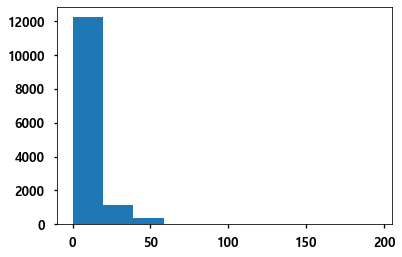

In [ ]:
plt.hist(sample_df['fare_amount'])

- 전형적인 치우친 왜도의 그래프
- 0~25달러구간이 압도적으로 많다.
- 이러한 데이터는 로그를 취해 정규분포형태로 변환 해줘야함

In [ ]:
# 위도경도의 정상범위 위도(-90~90), 경도(-180~180)의 범위에서 벗어난 데이터 (이상치) 탐색
Counter(train['pickup_latitude']<-90), Counter(train['pickup_latitude']>90)

(Counter({False: 13806091, True: 69}), Counter({False: 13805984, True: 176}))

In [ ]:
Counter(train['pickup_longitude']<-180), Counter(train['pickup_longitude']>180)

(Counter({False: 13805913, True: 247}), Counter({False: 13806104, True: 56}))

- 정상적인 위도 경도 범위에서 벗어나는 데이터가 존재
- 해당 데이터는 삭제하도록

In [ ]:
train = train.drop(train[train['pickup_latitude']<-90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_latitude']>90].index, axis=0).reset_index(drop=True)
Counter(train['pickup_latitude']>90)

Counter({False: 13805915})

In [ ]:
train = train.drop(train[train['dropoff_latitude']<-90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_latitude']>90].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude']<-180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['pickup_longitude']>180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_longitude']<-180].index, axis=0).reset_index(drop=True)
train = train.drop(train[train['dropoff_longitude']>180].index, axis=0).reset_index(drop=True)

train.shape

(13805499, 8)

- 위도경도는 처리햇고
- Key, Pickup_Datetime을 처리하도록 함

In [ ]:
train.iloc[:3, 2]

0   2012-04-21 04:30:42+00:00
1   2012-01-04 17:22:00+00:00
2   2012-12-24 11:24:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]